__Vu H. Chu-Le__

___

# Scenario

We are advising a client on the number of call center agents they need to handle their customer
support load. The provided data set shows the intervals between phone calls arriving during one day. Each value is a time in minutes indicating the amount of time that passed between receiving two consecutive phone calls.

To do this task, we start by modeling the number of phone calls we expect to come into the call
center during each hour of the day. 

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call_center.txt')

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

In [2]:
# Values of the parameter (λ) to evaluate
# Because λ > 0, we remove the value of 0
lambdas = np.linspace(0, 20, 501)[1:]

def likelihood(lambda_, datum):
    """
    Calculate the likelihood of the parameter given the data set.
    We use exponential distribution since it is the probability distribution 
    of the time between events, which is between two consecutive phone calls
    in our case. It supports non-negative continuous variable, which is also 
    appropriate here.
    
    Inputs:
    
        lambda_ (float): A parameter value to calculate the likelihood.
        
        datum (float/array of loat): A single datum or an array of data set.
    
    Returns: (float/array of float) The likelihood of the parameter given 
      the data.
    """
    return sts.expon(scale=1/lambda_).pdf(datum)

def prior(lambda_):
    """
    Calculate the prior probability distribution.
    
    Inputs:
    
        lambda_ (array of float): The range of parameter values at which to 
          evaluate the probability distribution.
          
    Returns: (array of float) The prior probability distribution.
    """
    return sts.gamma(1, scale=1/0.25).pdf(lambda_)

def compute_posterior(parameter_values, prior, likelihood, data):
    """
    Calculate the posterior probability distribution with given range of 
    parameter values, prior function, likelihood function, and the data set.
    
    Inputs:
        
        parameter_values (array of float): The list of parameter values at 
          which the probability distribution will be evaluated.
          
        prior (function): Function to calculate the prior probability
          distribution.
        
        likelihood (function): Function to calculate the likelihood.
        
        data (array of float): The given data set.
          
    Returns: (array of float) The posterior probability distribution.
    """
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

def compute_percentile(parameter_values, distribution_values, percentile):
    '''
    Compute the parameter value at a particular percentile of the given
    probability distribution values.

    Inputs:

        parameter_values (array of float): The list of parameter values at 
          which the probability distribution has been evaluated.

        distribution_values (array of float): The list of values of the 
          probability density function evaluated at the parameter values above.

        percentile (float): The value between 0 and 1 of the percentile 
          to compute.

    Returns: (float) The parameter value at the given percentile.
    '''
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return parameter_values[percentile_index]

In [3]:
# Lists to store the posterior mean and the 98% posterior confidence 
# interval bar length for the plot
posterior_means, errs = [], []

# Calculate posterior expected value of λ and 98% posterior confidence
# interval for each hour in the day
hours = range(len(waiting_times_per_hour))
for i in hours:
    print(f'Values for hour {i}:00-{i+1}:00')
    waiting_times_hour = waiting_times_per_hour[i]
    
    # Calculate the posterior distribution of λ
    posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)

    # Calculate the 98% posterior confidence interval over λ
    percentiles = [compute_percentile(lambdas, posterior, p) for p in [0.01, 0.99]]
    print('Posterior 98% interval:', percentiles, 'calls per minute')

    # Get the posterior expected value of λ
    lambda_ = sp.integrate.trapz(posterior * lambdas, lambdas)
    print('Expected value: λ =', lambda_, 'calls per minute\n')
    
    # Store the confidence interval bar length and the posterior mean
    errs.append(abs(percentiles-lambda_))
    posterior_means.append(lambda_)

Values for hour 0:00-1:00
Posterior 98% interval: [0.04, 0.2] calls per minute
Expected value: λ = 0.10259215928061097 calls per minute

Values for hour 1:00-2:00
Posterior 98% interval: [0.04, 0.16] calls per minute
Expected value: λ = 0.08180692157264402 calls per minute

Values for hour 2:00-3:00
Posterior 98% interval: [0.04, 0.16] calls per minute
Expected value: λ = 0.09546488432971513 calls per minute

Values for hour 3:00-4:00
Posterior 98% interval: [0.08, 0.44] calls per minute
Expected value: λ = 0.24267223608771513 calls per minute

Values for hour 4:00-5:00
Posterior 98% interval: [0.24, 0.64] calls per minute
Expected value: λ = 0.44233289646050655 calls per minute

Values for hour 5:00-6:00
Posterior 98% interval: [0.6, 1.2] calls per minute
Expected value: λ = 0.9033121445299432 calls per minute

Values for hour 6:00-7:00
Posterior 98% interval: [1.2, 1.96] calls per minute
Expected value: λ = 1.5911875564257962 calls per minute

Values for hour 7:00-8:00
Posterior 98% 

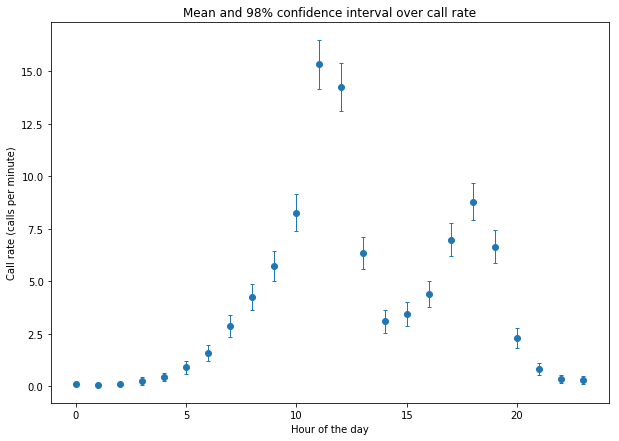

In [4]:
# Since errs has shape (24, 2), we need to transpose it to (2, 24)
# for the function to plot
plt.figure(figsize=(10, 7))
plt.errorbar(hours, posterior_means, yerr=np.array(errs).transpose(), 
             fmt='o', elinewidth=1, capsize=2)
plt.xlabel('Hour of the day')
plt.ylabel('Call rate (calls per minute)')
plt.title('Mean and 98% confidence interval over call rate')
plt.show()

From our analysis, we can see that the rate of calls per minute we expect to receive varies throughout the day and can be as low as roughly 0.1 calls per minute (around 6 calls an hour), and as high as over 15 calls per minute (over 900 calls an hour). During late evening and early morning, more specifically from 9pm (start of the 21st hour) to 6am (end of the 5th hour), the call rate is the lowest, with no more than one call per minute (60 calls an hour). We also have the highest confidence in the estimates for this time period, expecting an error of no more than 0.3 calls per minute. We expect the number of calls per minute to increase quickly from 6am, reaching over 8 calls per minute during 10-11am (nearly 500 calls per hour). There is a huge surge in calls from 11am-1pm, with our estimates of over 15 calls per minute (over 900 calls an hour) for 11am-12pm and over 14 calls per minute (over 840 calls an hour) for 12-1pm. Our estimates are less certain for these hours, but we can expect the number of calls to fall between 850 and 1000 calls from 11am-12pm and between 787 and 924 calls from 12-1pm 95% of the time. After that, the call rate drops significantly in the afternoon and evening, with the busiest hour being 6-7pm, with around 530 calls.

___

__1. The purpose of the function is to multiply the prior and likelihood passed as input arguments and to return the posterior as output. Explain how the function achieves this purpose using logarithms.__

According to the product rule of logarithms, $log_b(M \cdot N)=log_b(M) + log_b(N)$. In line 6 of the code, we calculate the sum of the log prior and the log likelihood, which would be the equivalent to the log of the product of the prior and likelihood. After normalization, this log would give us the log posterior, of which we take the exponential to get the posterior. Throughout the function, the same rule is applied, as seen when calculating the likelihood and normalizing the likelihood.

<br>

__2. What is the purpose of np.sum() in line 4?__

When calculating the likelihood of the parameter given a dataset, we multiply together the the likelihood of the parameter for each datum. However, since the function uses logarithms, we apply the product rule and take the sum of the log likelihoods instead. The result of this step (line 3-5) is an array with all the log likelihood for each of the values of the parameter ($\lambda$).

<br>

__3. Explain why the maximum of the unnormalized log posterior is subtracted in line 7.__

Applying the quotient rule of logarithms, $log_b(M) - log_b(N) = log_b(\frac {M}{N})$. Because the posterior is a probability function, each values in the posterior is a probability and needs to be within the range [0,1]. The maximum of the unnormalized log posterior is subtracted to make sure that all of these posterior probabilities would be within this range, as the maximum posterior probability (before normalizing) would be 1 (dividing by itself) and all the other posterior values are non-negative and smaller than the maximum posterior probability.

<br>

__4. Why do we still have to divide by the area in line 10 even after having subtracted the maximum of the unnormalized log posterior in line 7?__

Because the posterior is a probability function (and is continuous), it has to integrate to 1. The values we get in line 8 after getting the exponential of the unnormalized log posterior do not add up to 1, so we need to divide these values by the area so that they integrate to 1.

<br>

__5. Create an example where not taking logarithms would cause a problem. Create a prior, likelihood, and data set that fails to produce the correct posterior when we don’t take logs. Show all your code and visualize your results on one or more plots.__

When we calculate the posterior and do not take logarithms, overflow or underflow may arise. Overflow occurs when a calculation produces a result that is greater than what the computer can represent. This would happen when we have a huge dataset, a big range of parameter values, or the data and/or parameter have large values. Reversely, underflow occurs when a calculation produces a result that is too close to zero for the computer to represent it, and would happen when the data or parameter have miniscule numbers. Overflow and underflow are common when a function includes an exponential term since it grows very quickly. The code cell below shows an example of overflow and underflow: $e^{800}$ is evaluated to infinity, and $e^{-800}$ is evaluated to 0.

In [5]:
print(np.exp(800))
print(np.exp(-800))

inf
0.0


An example problem that would fail to produce the correct posterior when we do not take logs is as follows:

We signed up for a Zoology class and is having a class on heart rate of different animals. The professor wants us to model the number of heartbeats during an interval of 5 minutes we expect to hear from a group of animals of various unknown species. The professor provided us with a data set of the intervals between heartbeats, randomly switching between different species. The data set includes an undisclosed number of hours worth of data. Each value is a time in minute indicating the amount of time that passed between hearing two consecutive heartbeats. We would perform similar calculations as from previous sections for this problem.

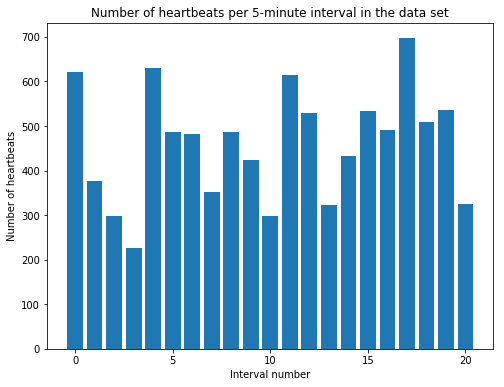

In [6]:
# Create a fake dataset
factor = 10**np.linspace(-3, 1, num=10000)
np.random.shuffle(factor)
data = np.concatenate([np.random.exponential(scale=1./200, 
                size=9000), np.random.exponential(scale=1./20, 
                size=1000)])*factor
np.random.shuffle(data)
# Separate data into different 5-minute intervals
num_of_intervals = int((np.sum(data))//5)+1
heartbeat_per_interval = [[] for _ in range(num_of_intervals)]

# Separate the data into intervals of 5 minutes
current_time = 0
for t in data:
    current_interval = int(current_time // 5)
    current_time += t
    heartbeat_per_interval[current_interval].append(t)
    
if round(sum(heartbeat_per_interval[-1])) != 5:
    heartbeat_per_interval = heartbeat_per_interval[:-1]
    num_of_intervals -= 1

# Plot the data
plt.figure(figsize=(8, 6))
plt.bar(range(num_of_intervals), [len(x) for x in heartbeat_per_interval])
plt.xlabel('Interval number')
plt.ylabel('Number of heartbeats')
plt.title('Number of heartbeats per 5-minute interval in the data set')
plt.show()

In [7]:
# Some whale species have heart rates as slow as 10  beats a minute, while
# a hummingbird even when resting can reach a heart rate of 350 beats/min.
# We will include any λ values between these two values.
new_lambdas = np.linspace(10, 350, 500)

def compute_posterior_without_log(parameter_values, prior, likelihood, data):
    """
    Calculate the posterior probability distribution with given range of 
    parameter values, prior function, likelihood function, and the data set.
    This function does not use logarithms.
    
    Inputs:
        
        parameter_values (array of float): The list of parameter values at 
          which the probability distribution will be evaluated.
          
        prior (function): Function to calculate the prior probability
          distribution.
        
        likelihood (function): Function to calculate the likelihood.
        
        data (array of float): The given data set.
          
    Returns: (array of float) The posterior probability distribution.
    """
    # Calculate the prior distribution and normalize it
    unnormalized_prior = prior(parameter_values)
    area = sp.integrate.trapz(unnormalized_prior, parameter_values)
    normalized_prior = unnormalized_prior / area
    
    # Calculate the likelihood for each parameter values given the data
    likelihood_param = []
    for param in parameter_values:
        # Take the product of the likelihoods for a parameter value
        # given each datum
        likelihood_param.append(np.prod(likelihood(param, data)))
    # Multiply the prior with the likelihood and normalize to get the
    # posterior
    unnormalized_posterior = normalized_prior * likelihood_param
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

# Find the posterior using the new function without logarithms.
# We use the same prior and likelihood function as above.
posterior = compute_posterior_without_log(new_lambdas, prior, likelihood, 
                                          heartbeat_per_interval[0])
lambda_ = sp.integrate.trapz(posterior * new_lambdas, new_lambdas)
print('Expected value: λ =', lambda_, 'calls per minute\n')

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Expected value: λ = nan calls per minute



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


In [8]:
# Print out some likelihood values
for value in new_lambdas[:10]:
    print(np.prod(likelihood(value, heartbeat_per_interval[0])))

inf
inf
inf
inf
inf
inf
inf
inf
inf
inf


Interval number 0
Expected value: λ = 118.43790388315304 beats per minute
Posterior 98% interval: [107.43486973947896, 129.23847695390782] beats per minute 

Interval number 1
Expected value: λ = 71.83000941866197 beats per minute
Posterior 98% interval: [63.14629258517034, 80.18036072144288] beats per minute 

Interval number 2
Expected value: λ = 54.54122233920743 beats per minute
Posterior 98% interval: [46.7935871743487, 61.78356713426854] beats per minute 

Interval number 3
Expected value: λ = 45.35667566603631 beats per minute
Posterior 98% interval: [37.93587174348697, 52.24448897795591] beats per minute 

Interval number 4
Expected value: λ = 115.99277288746285 beats per minute
Posterior 98% interval: [105.39078156312625, 126.51302605210421] beats per minute 

Interval number 5
Expected value: λ = 96.19284848390969 beats per minute
Posterior 98% interval: [86.312625250501, 106.07214428857715] beats per minute 

Interval number 6
Expected value: λ = 91.30632521233072 beats per 

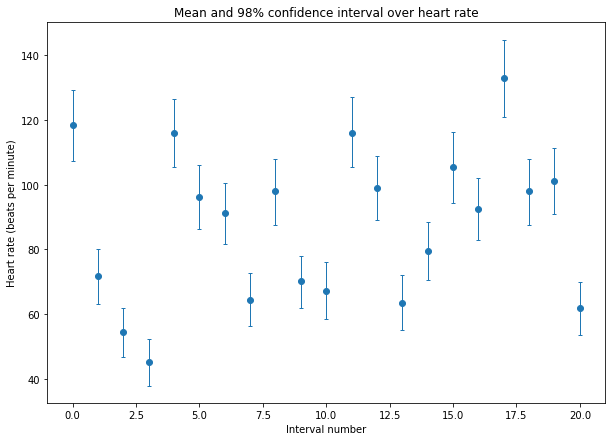

In [9]:
# Find the posterior using logarithms.
posterior_means, errs = [], []
for i in range(num_of_intervals):
    print(f'Interval number {i}')
    posterior = compute_posterior(new_lambdas, prior, likelihood, 
                                  heartbeat_per_interval[i])
    lambda_ = sp.integrate.trapz(posterior * new_lambdas, new_lambdas)
    print('Expected value: λ =', lambda_, 'beats per minute')
    posterior_means.append(lambda_)
    percentiles = [compute_percentile(new_lambdas, posterior, p) for p in [0.01, 0.99]]
    errs.append(abs(percentiles-lambda_))
    print('Posterior 98% interval:', percentiles, 'beats per minute \n')

# Plot the results
plt.figure(figsize=(10, 7))
plt.errorbar(range(num_of_intervals), posterior_means, yerr=np.array(errs).transpose(), 
             fmt='o', elinewidth=1, capsize=2)
plt.xlabel('Interval number')
plt.ylabel('Heart rate (beats per minute)')
plt.title('Mean and 98% confidence interval over heart rate')
plt.show()

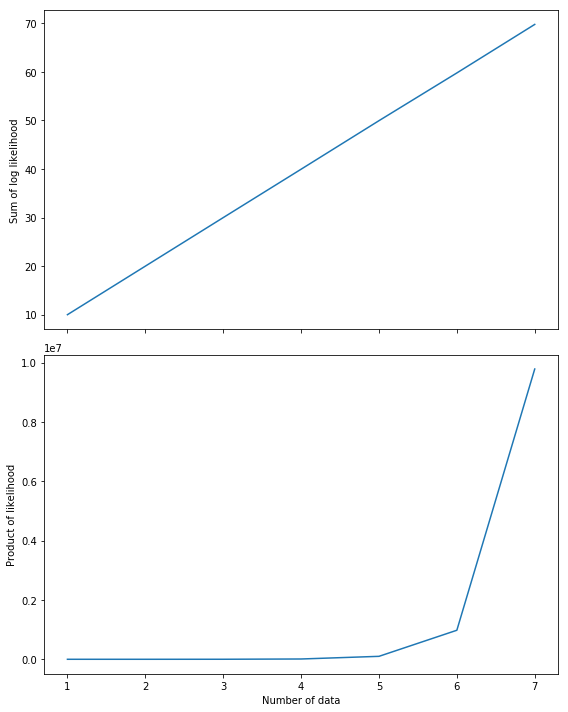

In [10]:
# An array of likelihoods for one of the parameter values given each
# datum in the data set.
likelihood_array = likelihood(new_lambdas[0], heartbeat_per_interval[10])
# Arrays to record the change in value as we consider more data points
likelihood_product = []
sum_log_likelihood = []
product = 1
sum_ = 0
for i in range(7):
    product *= likelihood_array[i]
    likelihood_product.append(product)
    sum_ += likelihood_array[i]
    sum_log_likelihood.append(sum_)

fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
ax[0].plot(range(1, 8), sum_log_likelihood)
ax[0].set_ylabel('Sum of log likelihood')
ax[1].plot(range(1, 8), likelihood_product)
ax[1].set_ylabel('Product of likelihood')
ax[1].set_xlabel('Number of data')
fig.tight_layout()
plt.show()

As seen above, in this case when we do not use logarithms, there are many data so the product of the likelihood for each parameter value gets too large and gives an overflow, hence failing to produce the correct posterior. Using logarithms works as expected. As seen in figure above, the product of the likelihood for each datum behave almost exponentially as the number of data increases, while in log space, the sum of log behaves linearly. Hence, when using logarithm the likelihood is well within the range of value that Python can handle.

___